<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/UV_Stellar_Catalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Imports**

In [1]:
!pip install pysynphot --quiet
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install git+https://github.com/astrofrog/sedfitter@master --quiet

     |████████████████████████████████| 10.8 MB 26.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [2]:
import pysynphot as S

/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.7/dist-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [3]:
!export PYSYN_CDBS=/my/local/dir/trds/

In [40]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from astropy.table import Table
from astropy.io import fits

import os
from time import perf_counter
import json
import requests
import pysynphot as S
import sedfitter as sed

import mastcasjobs

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"


matplotlib.rcParams['font.size']=15
matplotlib.rcParams['figure.figsize']=(15,10)
sb.set_style('darkgrid')

In [5]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (369/369), done.
remote: Compressing objects: 100% (245/245), done.
remote: Total 369 (delta 184), reused 229 (delta 110), pack-reused 0
Receiving objects: 100% (369/369), 46.00 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [6]:
cd INSIST/data

/content/INSIST/data


# **CasJobs**

## **Script**

In [7]:
def mastQuery(request, json_return=False):
    """Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object
    
    Returns the text response or (if json_return=True) the json response
    """
    
    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)
    
    # make the query
    r = requests.post(url, data=dict(request=requestString))
    
    # raise exception on error
    r.raise_for_status()
    
    if json_return:
        return r.json()
    else:
        return r.text


def resolve(name):
    """Get the RA and Dec for an object using the MAST name resolver
    
    Parameters
    ----------
    name (str): Name of object

    Returns RA, Dec tuple with position"""

    resolverRequest = {'service':'Mast.Name.Lookup',
                       'params':{'input':name,
                                 'format':'json'
                                },
                      }
    resolvedObject = mastQuery(resolverRequest, json_return=True)
    # The resolver returns a variety of information about the resolved object, 
    # however for our purposes all we need are the RA and Dec
    try:
        objRa = resolvedObject['resolvedCoordinate'][0]['ra']
        objDec = resolvedObject['resolvedCoordinate'][0]['decl']
    except IndexError as e:
        raise ValueError("Unknown object '{}'".format(name))
    return (objRa, objDec)

In [8]:
class casjobs():
    """PSF Generator using Source catalog or CasJobs GALEX Catalog

    Parameters
    ----------
    name (string) : Catalog name or coordinates of the source

    df   (pd.DataFrame ): Pandas dataframe with source catalog

    cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

        'ra' (degrees)

        'dec' (degrees)

        'mag_nuv' (ABmag)

    pixel_scale (float) : pixel scale of detector in the unit of arcseconds/pixels

    fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

    n_pix_main (int) : Number of pixels along one axis in the detector. Total number of pixels in the detector is n_pix_main**2

    n_pix_sub (int) : Number of pixels along one axis in the path. Total number of pixels in the patch is n_pix_sub**2

    """
    def __init__(self,name = None, df = None ,cols = None):   

        if name is not None and df is None:
          self.name = name
          self.ra,self.dec = resolve(name)
      
          self.jobs = mastcasjobs.MastCasJobs(context="PanSTARRS_DR2")
          self.query =   f"""select psc.objid,o.raStack,o.decStack,mag.gPSFMag, mag.gPSFMagErr,mag.rPSFMag, mag.rPSFMagErr,mag.iPSFMag, mag.iPSFMagErr,mag.zPSFMag,mag.zPSFMagErr, mag.yPSFMag,mag.yPSFMagErr,psc.ps_score
                            from fGetNearbyObjEq({self.ra}, {self.dec}, 10) f
                            join ObjectThin o on o.objid=f.objid
                            join HLSP_PS1_PSC.pointsource_scores psc on psc.objid=f.objid
                            join StackObjectThin mag on mag.objid=psc.objid
                            WHERE
                            mag.gPSFMag>-900 and 
                            mag.rPSFMag>-900 and 
                            mag.iPSFMag>-900 and 
                            mag.zPSFMag>-900 and 
                            mag.yPSFMag>-900 
                          """
          self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()
        else:
          self.df = df 
        if cols is not None:
          self.df = self.df.rename(columns=cols) 
    
    def show_field(self,figsize=(10,10)):
      """
      Function for creating a scatter plot of sources within the FoV
      
      Returns
      -------
      fig, ax
      """
        
      fig, ax = plt.subplots(1,1,figsize=figsize)
      ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
      ax.set_title(f" Requested Center : {self.name} \n  {len(self.df)} sources")
      ax.invert_xaxis()
      ax.set_xlabel('RA (Degrees)')
      ax.set_ylabel('Dec (Degrees)')
      return fig,ax
      
        

## **Query**

In [9]:
obj = casjobs('M 67', cols = {'raStack':'ra','decStack':'dec'})

In [10]:
df_star = obj.df[obj.df['ps_score']>0.5].copy()

In [11]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score
2,121971328494717854,132.849460,11.647811,14.8691,0.000533,14.3603,0.000274,14.2388,0.000320,14.2280,0.000519,14.1805,0.000877,0.997500
3,121981327802535449,132.780255,11.654201,22.4085,0.070046,21.0757,0.020825,19.8949,0.010747,19.3878,0.012878,19.2221,0.028750,0.967161
7,121981328054472261,132.805456,11.651512,20.5329,0.016547,20.0120,0.012918,19.6550,0.009876,19.5985,0.015401,19.5313,0.032895,0.973104
8,121981328218108430,132.821806,11.656615,21.3080,0.035670,20.0955,0.021422,18.9608,0.006396,18.4705,0.006572,18.1437,0.010728,0.987833
10,121981328277113751,132.827729,11.652668,21.9420,0.059630,20.6828,0.015879,19.3339,0.007499,18.8097,0.007518,18.4563,0.013550,0.969271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.2652,0.000371,13.9342,0.000273,13.8645,0.000378,13.8345,0.000453,13.7998,0.000760,0.998333
1826,122361328754558683,132.875457,11.973499,14.2070,0.000346,13.9596,0.000281,13.8724,0.000384,13.8300,0.000452,13.8094,0.000760,0.998333
1827,122361328818090634,132.881819,11.966787,16.9712,0.001754,16.5763,0.001196,16.2176,0.002029,16.4170,0.002133,16.3843,0.003584,0.997500
1828,122371328134963003,132.813494,11.977090,14.2162,0.000410,13.8419,0.000236,13.6946,0.000315,13.6735,0.000408,13.6380,0.000744,0.994167


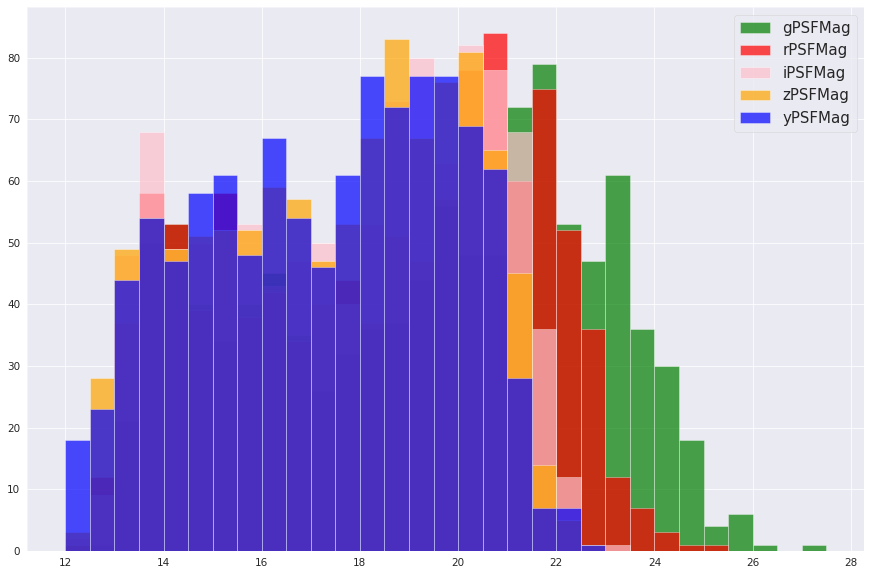

In [12]:
bin_min = 12
bin_max = 28
step  = 0.5
bins = np.arange(bin_min,bin_max, step)

plt.hist(df_star['gPSFMag'],bins=bins,alpha=0.7,color = 'green')
plt.hist(df_star['rPSFMag'],bins=bins,alpha=0.7,color = 'red')
plt.hist(df_star['iPSFMag'],bins=bins,alpha=0.7,color = 'pink')
plt.hist(df_star['zPSFMag'],bins=bins,alpha=0.7,color = 'orange')
plt.hist(df_star['yPSFMag'],bins=bins,alpha=0.7,color = 'blue');
plt.legend(['gPSFMag','rPSFMag','iPSFMag','zPSFMag','yPSFMag',])

# **Synthetic Spectra**

In [66]:
for i in ['g','r','i','z','y']:
  df_star[f'{i}PSFFlux']     = 3631*pow(10,-df_star[f'{i}PSFMag']/2.5)*1000
  df_star[f'{i}PSFFlux_err'] = 1.09*df_star[f'{i}PSFMagErr']/df_star[f'{i}PSFMag']*1000

In [67]:
df_star['g_flag'] =1
df_star['i_flag'] =1
df_star['r_flag'] =1
df_star['z_flag'] =1
df_star['y_flag'] =1

In [68]:
df_star

,objid,ra,dec,gPSFMag,gPSFMagErr,rPSFMag,rPSFMagErr,iPSFMag,iPSFMagErr,zPSFMag,zPSFMagErr,yPSFMag,yPSFMagErr,ps_score,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err,g_flag,i_flag,r_flag,z_flag,y_flag
2,121971328494717854,132.849460,11.647811,14.8691,0.000533,14.3603,0.000274,14.2388,0.000320,14.2280,0.000519,14.1805,0.000877,0.997500,4.096248,0.039072,6.544949,0.020798,7.319919,0.024496,7.393094,0.039760,7.723715,0.067412,1,1,1,1,1
3,121981327802535449,132.780255,11.654201,22.4085,0.070046,21.0757,0.020825,19.8949,0.010747,19.3878,0.012878,19.2221,0.028750,0.967161,0.003950,3.407195,0.013482,1.077034,0.040001,0.588806,0.063813,0.724013,0.074334,1.630285,1,1,1,1,1
7,121981328054472261,132.805456,11.651512,20.5329,0.016547,20.0120,0.012918,19.6550,0.009876,19.5985,0.015401,19.5313,0.032895,0.973104,0.022226,0.878406,0.035911,0.703609,0.049891,0.547690,0.052556,0.856550,0.055912,1.835799,1,1,1,1,1
8,121981328218108430,132.821806,11.656615,21.3080,0.035670,20.0955,0.021422,18.9608,0.006396,18.4705,0.006572,18.1437,0.010728,0.987833,0.010885,1.824681,0.033253,1.161951,0.094560,0.367687,0.148534,0.387834,0.200699,0.644495,1,1,1,1,1
10,121981328277113751,132.827729,11.652668,21.9420,0.059630,20.6828,0.015879,19.3339,0.007499,18.8097,0.007518,18.4563,0.013550,0.969271,0.006071,2.962205,0.019360,0.836836,0.067060,0.422776,0.108679,0.435659,0.150490,0.800242,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,14.2652,0.000371,13.9342,0.000273,13.8645,0.000378,13.8345,0.000453,13.7998,0.000760,0.998333,7.144079,0.028348,9.690501,0.021355,10.332996,0.029718,10.622488,0.035691,10.967465,0.060030,1,1,1,1,1
1826,122361328754558683,132.875457,11.973499,14.2070,0.000346,13.9596,0.000281,13.8724,0.000384,13.8300,0.000452,13.8094,0.000760,0.998333,7.537481,0.026546,9.466430,0.021941,10.258084,0.030172,10.666606,0.035624,10.870919,0.059988,1,1,1,1,1
1827,122361328818090634,132.881819,11.966787,16.9712,0.001754,16.5763,0.001196,16.2176,0.002029,16.4170,0.002133,16.3843,0.003584,0.997500,0.590944,0.112653,0.850171,0.078645,1.183004,0.136371,0.984524,0.141620,1.014627,0.238433,1,1,1,1,1
1828,122371328134963003,132.813494,11.977090,14.2162,0.000410,13.8419,0.000236,13.6946,0.000315,13.6735,0.000408,13.6380,0.000744,0.994167,7.473882,0.031436,10.550335,0.018584,12.083319,0.025072,12.320441,0.032524,12.729937,0.059463,1,1,1,1,1


In [69]:
df_out=df_star[['objid', 'ra', 'dec', 'g_flag', 'i_flag', 'r_flag', 'z_flag','y_flag','gPSFFlux','gPSFFlux_err','rPSFFlux', 'rPSFFlux_err','iPSFFlux', 'iPSFFlux_err','zPSFFlux', 'zPSFFlux_err','yPSFFlux', 'yPSFFlux_err']]

In [70]:
df_out

,objid,ra,dec,g_flag,i_flag,r_flag,z_flag,y_flag,gPSFFlux,gPSFFlux_err,rPSFFlux,rPSFFlux_err,iPSFFlux,iPSFFlux_err,zPSFFlux,zPSFFlux_err,yPSFFlux,yPSFFlux_err
2,121971328494717854,132.849460,11.647811,1,1,1,1,1,4.096248,0.039072,6.544949,0.020798,7.319919,0.024496,7.393094,0.039760,7.723715,0.067412
3,121981327802535449,132.780255,11.654201,1,1,1,1,1,0.003950,3.407195,0.013482,1.077034,0.040001,0.588806,0.063813,0.724013,0.074334,1.630285
7,121981328054472261,132.805456,11.651512,1,1,1,1,1,0.022226,0.878406,0.035911,0.703609,0.049891,0.547690,0.052556,0.856550,0.055912,1.835799
8,121981328218108430,132.821806,11.656615,1,1,1,1,1,0.010885,1.824681,0.033253,1.161951,0.094560,0.367687,0.148534,0.387834,0.200699,0.644495
10,121981328277113751,132.827729,11.652668,1,1,1,1,1,0.006071,2.962205,0.019360,0.836836,0.067060,0.422776,0.108679,0.435659,0.150490,0.800242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1825,122361328754558683,132.875457,11.973499,1,1,1,1,1,7.144079,0.028348,9.690501,0.021355,10.332996,0.029718,10.622488,0.035691,10.967465,0.060030
1826,122361328754558683,132.875457,11.973499,1,1,1,1,1,7.537481,0.026546,9.466430,0.021941,10.258084,0.030172,10.666606,0.035624,10.870919,0.059988
1827,122361328818090634,132.881819,11.966787,1,1,1,1,1,0.590944,0.112653,0.850171,0.078645,1.183004,0.136371,0.984524,0.141620,1.014627,0.238433
1828,122371328134963003,132.813494,11.977090,1,1,1,1,1,7.473882,0.031436,10.550335,0.018584,12.083319,0.025072,12.320441,0.032524,12.729937,0.059463


In [25]:
df_out.to_csv('data_input.dat',index=False, header=False)

## **Model**

In [133]:
if os.path.exists('models_kurucz'):
  os.system('rm -r models_kurucz')

In [134]:
!curl -o models ftp://ftp.astro.wisc.edu/outgoing/tom/model_packages/models_kurucz_05sep11.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 83.0M  100 83.0M    0     0  7742k      0  0:00:10  0:00:10 --:--:-- 15.0M


In [135]:
!tar -xzf models

In [136]:
!rm models

## **Formating data**

In [138]:
model_dir = 'models_kurucz'

PS1g = sed.filter.Filter()
PS1g.name = "PS1g"
PS1g.central_wavelength = (4881.47 * u.angstrom).to(u.micron)
PS1g_wl, PS1g_rsr = np.loadtxt('PAN-STARRS_PS1.g.dat', usecols=(0, 1), unpack=True)
PS1g.nu = 3.0e18 * u.Hz / PS1g_wl
PS1g.response = PS1g_rsr 
PS1g.normalize()

PS1r = sed.filter.Filter()
PS1r.name = "PS1r"
PS1r.central_wavelength = (6198.41 * u.angstrom).to(u.micron)
PS1r_wl, PS1r_rsr = np.loadtxt('PAN-STARRS_PS1.r.dat', usecols=(0, 1), unpack=True)
PS1r.nu = 3.0e18 * u.Hz /PS1r_wl
PS1r.response = PS1r_rsr 
PS1r.normalize()

PS1i = sed.filter.Filter()
PS1i.name = "PS1i"
PS1i.central_wavelength = (7549.34 * u.angstrom).to(u.micron)
PS1i_wl, PS1i_rsr = np.loadtxt('PAN-STARRS_PS1.i.dat', usecols=(0, 1), unpack=True)
PS1i.nu = 3.0e18 * u.Hz / PS1i_wl
PS1i.response = PS1i_rsr 
PS1i.normalize()

PS1z = sed.filter.Filter()
PS1z.name = "PS1z"
PS1z.central_wavelength = (8701.37 * u.angstrom).to(u.micron)
PS1z_wl, PS1z_rsr = np.loadtxt('PAN-STARRS_PS1.z.dat', usecols=(0, 1), unpack=True)
PS1z.nu = 3.0e18 * u.Hz / PS1z_wl
PS1z.response = PS1z_rsr 
PS1z.normalize()

PS1y = sed.filter.Filter()
PS1y.name = "PS1y"
PS1y.central_wavelength = (9509.80 * u.angstrom).to(u.micron)
PS1y_wl, PS1y_rsr = np.loadtxt('PAN-STARRS_PS1.y.dat', usecols=(0, 1), unpack=True)
PS1y.nu = 3.0e18 * u.Hz / PS1y_wl
PS1y.response = PS1y_rsr
PS1y.normalize()


In [ ]:
sed.convolve.convolve_model_dir(model_dir, [PS1g, PS1r, PS1i, PS1z,PS1y])

INFO: 3808 SEDs found in models_kurucz [sedfitter.convolve.convolve]
INFO: Rebinning filters [sedfitter.convolve.convolve]


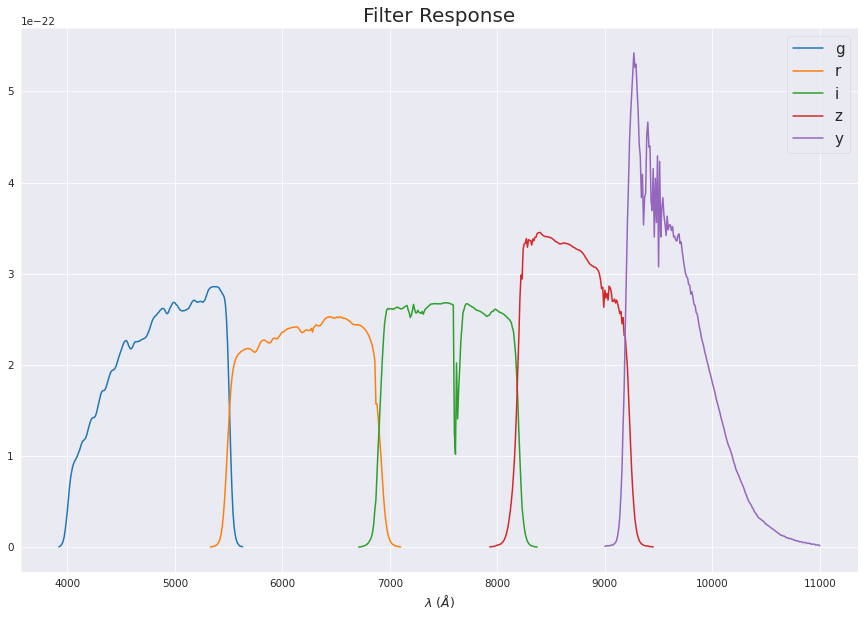

In [114]:
plt.figure(figsize = (15,10))
plt.plot(PS1g_wl,PS1g.response)
plt.plot(PS1r_wl,PS1r.response)
plt.plot(PS1i_wl,PS1i.response)
plt.plot(PS1z_wl,PS1z.response)
plt.plot(PS1y_wl,PS1y.response)
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.title('Filter Response',size=20)
plt.legend(['g','r','i','z','y'])

In [126]:
test = Table.read('models_kurucz/convolved/NEW_FILT.fits',hdu=1)

In [127]:
test

MODEL_NAME,TOTAL_FLUX [1],TOTAL_FLUX_ERR [1]
,mJy,mJy
bytes30,float64,float64
kt03500g+0.0z+0.0,5449291832.315666,27291509.16594212
kt03500g+0.0z+0.2,5471901717.886896,27404692.27118163
kt03500g+0.0z+0.5,5504093489.15638,27565601.845098563
kt03500g+0.0z-0.5,5385809182.478768,26973403.61278389
kt03500g+0.0z-1.0,5317945278.0340395,26637790.967846498
kt03500g+0.0z-1.5,5279418911.067672,26446768.29841218
kt03500g+0.0z-2.0,5292812040.088829,26513878.937514473
kt03500g+0.0z-2.5,5339594902.991652,26749129.31733567


In [118]:
model_dir = 'models_kurucz'

# Read in extinction law)
extinction = sed.Extinction.from_file('kmh94.par', columns=[0, 3],
                                  wav_unit=u.micron, chi_unit=u.cm**2 / u.g)

# Define filters and apertures
filters = ['PS1g', 'PS1r', 'PS1i', 'PS1z', 'PS1y']
apertures = [3., 3., 3., 3., 3.]*u.arcsec

# Run the fitting
fitter = sed.fit('data_input.dat', filters, apertures, model_dir,'output.fitinfo',extinction_law=extinction,distance_range=[1., 2.] * u.kpc,av_range=[0., 40.])

 ------------------------------------------------------------
  => Model parameters
 ------------------------------------------------------------

   Models              :  Kurucz stellar photospheres
   Log[d] stepping     :  0.02

 ------------------------------------------------------------
  => Reading in convolved fluxes
 ------------------------------------------------------------

   Reading models_kurucz/convolved/PS1g.fits
   Reading models_kurucz/convolved/PS1r.fits
   Reading models_kurucz/convolved/PS1i.fits
   Reading models_kurucz/convolved/PS1z.fits
   Reading models_kurucz/convolved/PS1y.fits
 ------------------------------------------------------------
  => Fitting parameters
 ------------------------------------------------------------

   Minimum A_V      :     0.000 mag
   Maximum A_V      :    40.000 mag
   Minimum distance :     1.000 kpc
   Maximum distance :     2.000 kpc

 ------------------------------------------------------------
  => Output parameters
 ----

In [35]:
apertures

<Quantity [3., 3., 3., 3., 3.] arcsec>

In [34]:
sed.write_parameter_ranges('output.fitinfo', 'parameter_ranges.txt', select_format=('F', 6.))

EOFError: ignored

In [ ]:
with open('parameter_ranges.txt','rt') as f:
  d = f.readlines()
f.close()
dat = []
for i in d[4:]:
  dat.append(i.split()) 
df = pd.DataFrame(dat, columns=d[1].split())

In [ ]:
df

,source_name,n_data,n_fits,min,best,max,min,best,max,min,best,max,min,best,max,min,best,max,min,best,max
0,121981327802535456,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,121981328054472256,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,121981328218108432,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,121981328277113744,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,121981328281945200,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,122361328754558688,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1053,122361328754558688,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1054,122361328818090640,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1055,122371328134963008,5,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
